Load Dataset

In [1]:
import pandas as pd
df = pd.read_csv("../data/processed/annotations.csv")
print(df.head())

       image   xmin        ymin        xmax        ymax   class_label
0  img_0.jpg  184.0  193.000000  196.000000  215.000000  without_mask
1  img_1.jpg   17.0  197.000000   28.000000  223.000000  without_mask
2  img_2.jpg  289.0  110.000000  303.000000  135.000000     with_mask
3  img_3.jpg  260.0  380.000000  272.000000  404.000000  without_mask
4  img_4.jpg    6.0   93.999999   41.999999  151.000006  without_mask


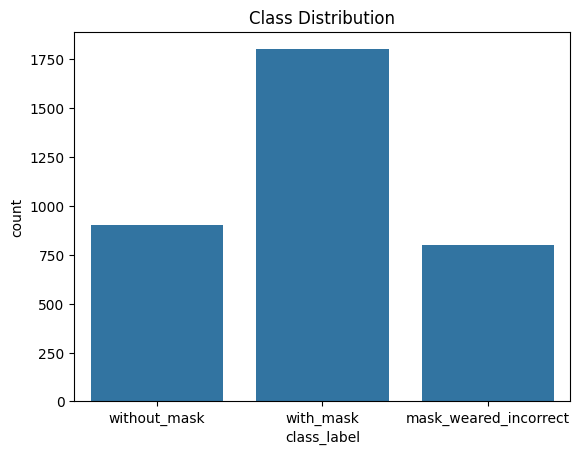

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="class_label", data=df)
plt.title("Class Distribution")
plt.show()

Bounding box statistics


What’s happening
Computes absolute bounding box size (in pixels)
This is done after resizing to 416×416
So:
Width/height values are comparable across images
No scale ambiguity
Why this matters
Bounding box size tells you:
Face scale variation
Detection difficulty
Suitability of input resolution

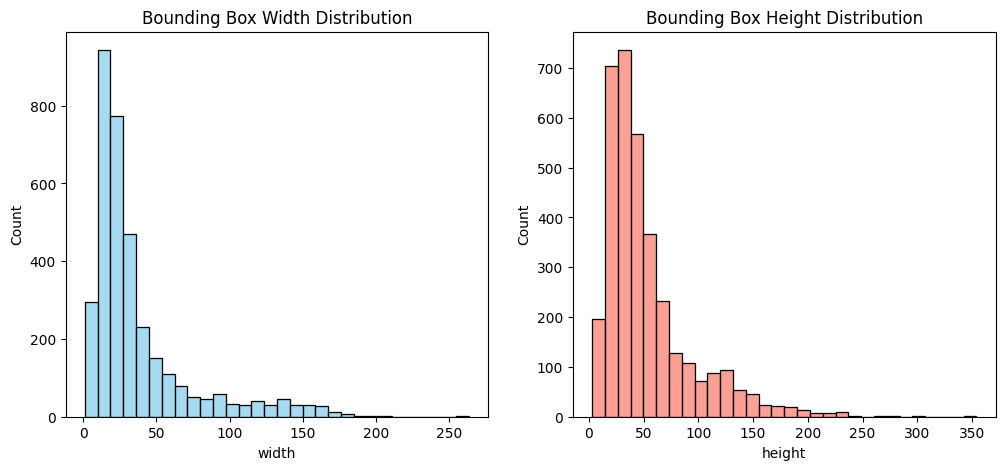

In [6]:
df['width'] = df['xmax'] - df['xmin']
df['height'] = df['ymax'] - df['ymin']

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(df['width'], bins=30, color='skyblue')
plt.title("Bounding Box Width Distribution")

plt.subplot(1,2,2)
sns.histplot(df['height'], bins=30, color='salmon')
plt.title("Bounding Box Height Distribution")
plt.show()

Visualizing bounding boxes

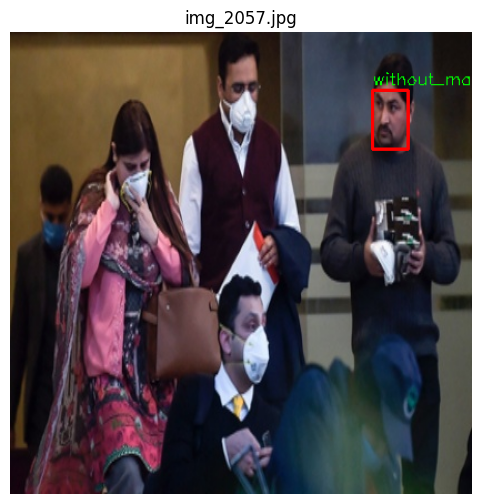

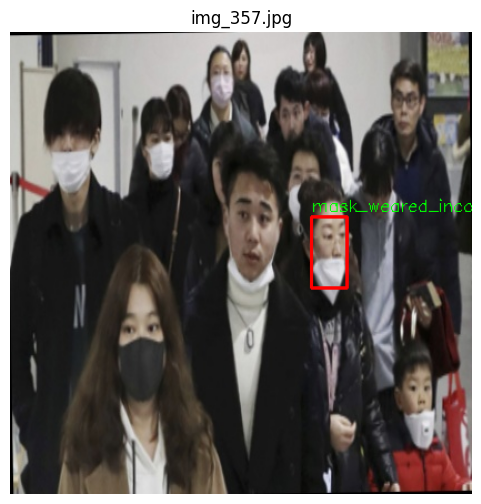

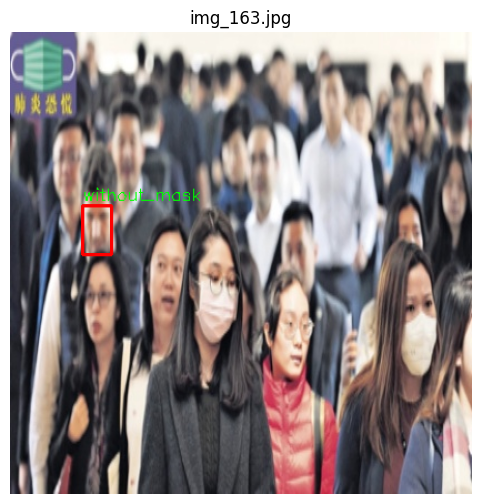

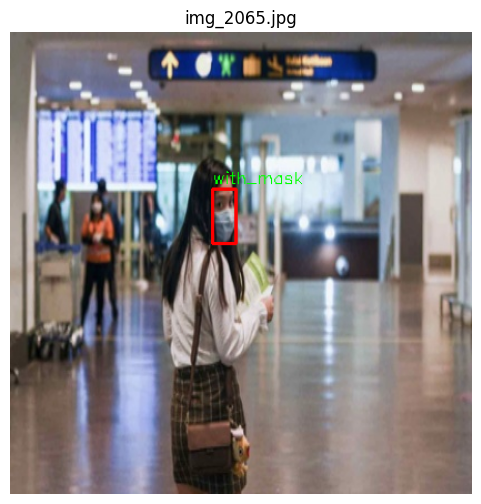

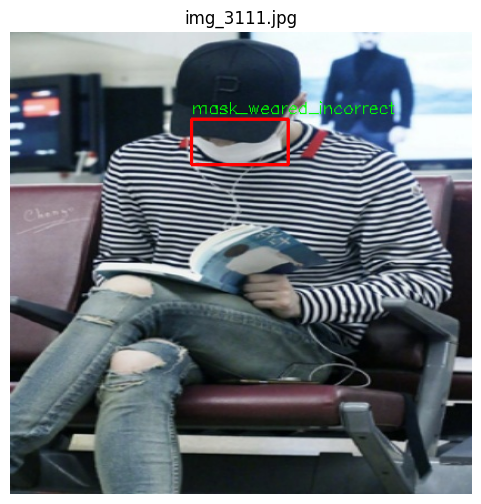

In [5]:
# Step 5: Visual inspection of images with bounding boxes

import cv2
import matplotlib.pyplot as plt
import random
from pathlib import Path

# Resolve project root and image directory safely
PROJECT_ROOT = Path.cwd().parent          # notebooks → project root
IMAGE_DIR = PROJECT_ROOT / "data" / "processed" / "images"

# Randomly sample 5 images from the dataset
sample_images = random.sample(list(df['image'].unique()), 5)

for img_file in sample_images:
    img_path = IMAGE_DIR / img_file
    img = cv2.imread(str(img_path))

    # Safety check in case image is missing
    if img is None:
        print(f"⚠️ Image not found or could not be loaded: {img_path}")
        continue

    # Convert BGR (OpenCV default) to RGB for matplotlib
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Get all bounding boxes for this image
    boxes = df[df['image'] == img_file]

    for _, row in boxes.iterrows():
        cv2.rectangle(
            img,
            (int(row['xmin']), int(row['ymin'])),
            (int(row['xmax']), int(row['ymax'])),
            (255, 0, 0),
            2
        )
        cv2.putText(
            img,
            row['class_label'],
            (int(row['xmin']), int(row['ymin']) - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (0, 255, 0),
            1
        )

    # Display image
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(img_file)
    plt.axis("off")
    plt.show()


Objects per Image (Scene Complexity)

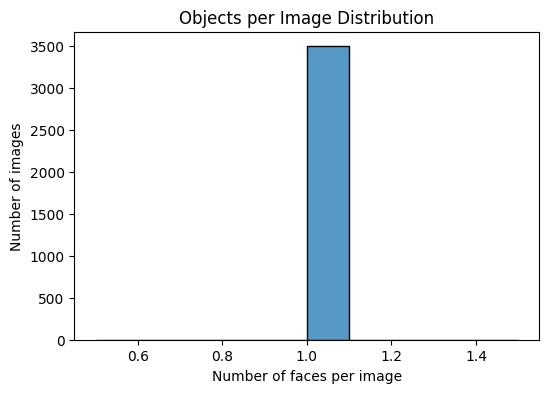

In [7]:
obj_per_image = df.groupby("image").size()

plt.figure(figsize=(6,4))
sns.histplot(obj_per_image, bins=10)
plt.xlabel("Number of faces per image")
plt.ylabel("Number of images")
plt.title("Objects per Image Distribution")
plt.show()

Class Distribution per Image (Not Just Objects)

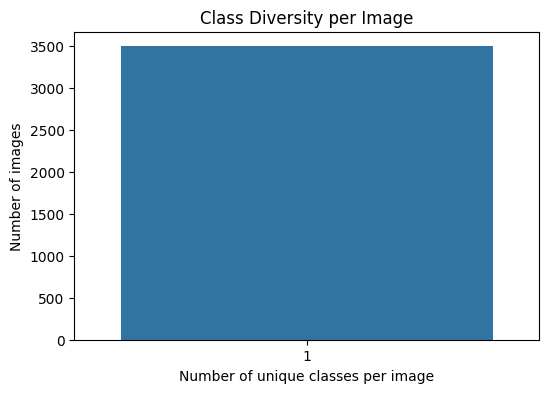

In [8]:
class_per_image = (
    df.groupby("image")["class_label"]
      .nunique()
)

plt.figure(figsize=(6,4))
sns.countplot(x=class_per_image)
plt.xlabel("Number of unique classes per image")
plt.ylabel("Number of images")
plt.title("Class Diversity per Image")
plt.show()

Bounding Box Area Distribution

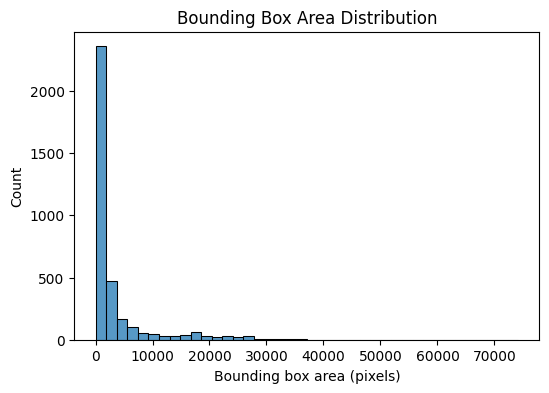

In [9]:
df['area'] = df['width'] * df['height']

plt.figure(figsize=(6,4))
sns.histplot(df['area'], bins=40)
plt.xlabel("Bounding box area (pixels)")
plt.title("Bounding Box Area Distribution")
plt.show()

Bounding Box Area by Class (Excellent Insight)

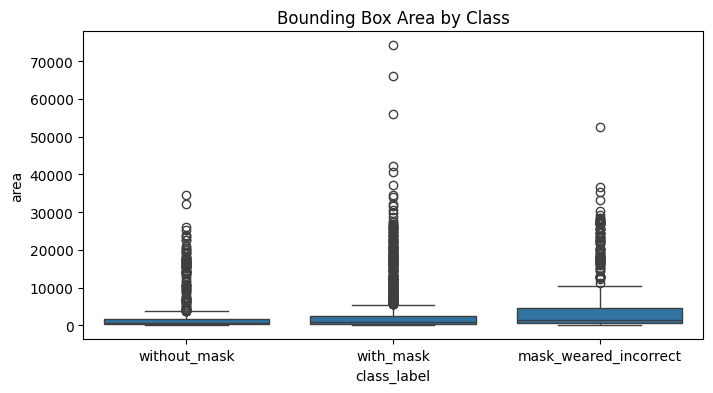

In [10]:
plt.figure(figsize=(8,4))
sns.boxplot(
    x="class_label",
    y="area",
    data=df
)
plt.title("Bounding Box Area by Class")
plt.show()

Aspect Ratio Analysis (Advanced but Simple)

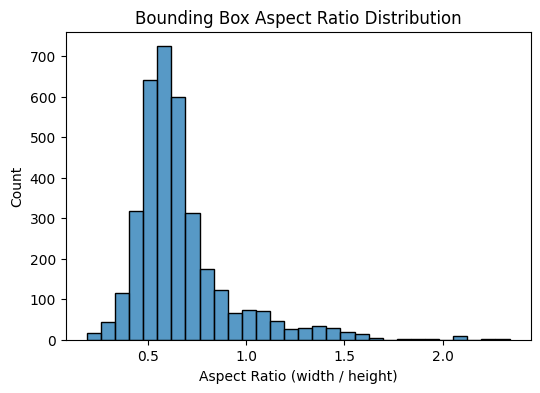

In [11]:
df['aspect_ratio'] = df['width'] / df['height']

plt.figure(figsize=(6,4))
sns.histplot(df['aspect_ratio'], bins=30)
plt.xlabel("Aspect Ratio (width / height)")
plt.title("Bounding Box Aspect Ratio Distribution")
plt.show()

Image Resolution Consistency Check (Sanity EDA)

In [12]:
from PIL import Image

sizes = []

for img_name in df['image'].unique()[:200]:
    img_path = IMAGE_DIR / img_name
    with Image.open(img_path) as img:
        sizes.append(img.size)

sizes_df = pd.DataFrame(sizes, columns=["width", "height"])
sizes_df.describe()


,width,height
count,200.0,200.0
mean,416.0,416.0
std,0.0,0.0
min,416.0,416.0
25%,416.0,416.0
50%,416.0,416.0
75%,416.0,416.0
max,416.0,416.0


Sample Images by Class (Presentation Gold ⭐)

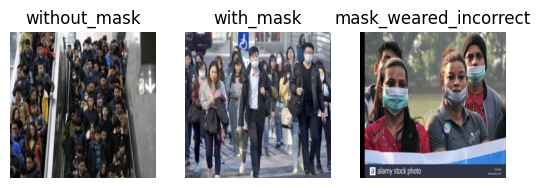

In [27]:
classes = df['class_label'].unique()

for i, cls in enumerate(classes):
    img_name = df[df['class_label'] == cls]['image'].iloc[0]
    img = cv2.imread(str(IMAGE_DIR / img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, len(classes), i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")
